<a href="https://colab.research.google.com/github/HamzaQureshi12/LLM_Assignment_02/blob/main/LLM_Assignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Device Setup

In [ ]:
!pip install --upgrade --force-reinstall fsspec datasets
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud import WordCloud
# To set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device in use:", device)

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.33.2-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py

Device in use: cuda


# Load IMDb Dataset

In [ ]:

imdb_data = load_dataset("imdb")
df_train_set = pd.DataFrame(imdb_data['train'])
df_test_set = pd.DataFrame(imdb_data['test'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Data Visualization: Label Distribution and Review Length

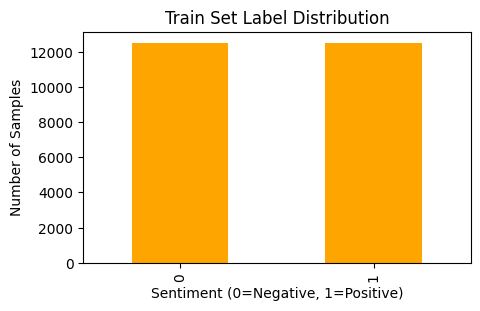

In [ ]:
plt.figure(figsize=(5,3))
df_train_set['label'].value_counts().plot(kind='bar', color='orange')
plt.title('Train Set Label Distribution')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Number of Samples')
plt.show()

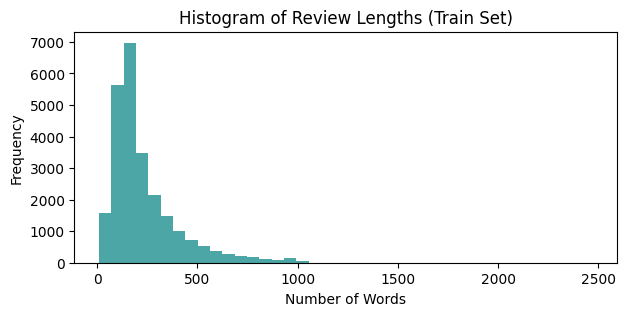

In [ ]:
plt.figure(figsize=(7,3))
df_train_set['review_length'] = df_train_set['text'].apply(lambda x: len(x.split()))
plt.hist(df_train_set['review_length'], bins=40, color='teal', alpha=0.7)
plt.title('Histogram of Review Lengths (Train Set)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


# Word Clouds for Positive/Negative Reviews

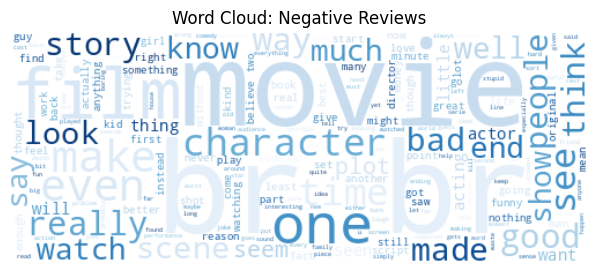

In [ ]:
negative_texts = " ".join(df_train_set[df_train_set['label']==0]['text'])
positive_texts = " ".join(df_train_set[df_train_set['label']==1]['text'])

wordcloud_neg = WordCloud(width=500, height=200, background_color='white', colormap='Blues').generate(negative_texts)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Negative Reviews')
plt.show()

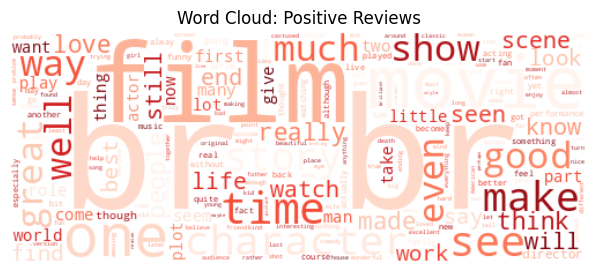

In [ ]:
wordcloud_pos = WordCloud(width=500, height=200, background_color='white', colormap='Reds').generate(positive_texts)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Positive Reviews')
plt.show()

# Prepare Training and Test Lists

In [ ]:
train_reviews = df_train_set['text'].tolist()
train_targets = df_train_set['label'].tolist()
test_reviews = df_test_set['text'].tolist()
test_targets = df_test_set['label'].tolist()

# 7. Define Custom Dataset Class for PyTorch
class MovieReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, index):
        encoded = self.tokenizer(self.reviews[index],
                                 truncation=True,
                                 padding='max_length',
                                 max_length=self.max_len,
                                 return_tensors='pt')
        # Remove batch dimension for DataLoader compatibility
        data_item = {key: val.squeeze(0) for key, val in encoded.items()}
        data_item['labels'] = torch.tensor(self.targets[index], dtype=torch.long)
        return data_item

# Tokenizer & DataLoader Setup

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_seq_length = 256

train_dataset_full = MovieReviewDataset(train_reviews, train_targets, bert_tokenizer, max_seq_length)
test_dataset_full = MovieReviewDataset(test_reviews, test_targets, bert_tokenizer, max_seq_length)

train_loader_full = DataLoader(train_dataset_full, batch_size=16, shuffle=True)
test_loader_full = DataLoader(test_dataset_full, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Initialize BERT Model for Sequence Classification

In [ ]:
sentiment_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
sentiment_model = sentiment_model.to(device)

optimizer_bert = AdamW(sentiment_model.parameters(), lr=2e-5)
loss_function = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Show Sample Comments and Labels (Before Training)

In [ ]:
print("\nSample test comments and labels (before training):\n")
for i in range(3):
    print(f"Review: {test_reviews[i][:120]}...")
    print(f"True label: {test_targets[i]}")
    print("")


Sample test comments and labels (before training):

Review: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misun...
True label: 0

Review: Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases,...
True label: 0

Review: its a totally average film with a few semi-alright action sequences that make the plot seem a little better and remind t...
True label: 0



# Model Tranining

In [ ]:
num_training_epochs = 15
train_loss_history = []

for epoch in range(num_training_epochs):
    sentiment_model.train()
    running_loss = 0.0
    for batch in train_loader_full:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer_bert.zero_grad()
        outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_bert.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader_full)
    train_loss_history.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_training_epochs} | Training Loss: {avg_train_loss:.4f}")

Epoch 1/15 | Training Loss: 0.2638
Epoch 2/15 | Training Loss: 0.1387
Epoch 3/15 | Training Loss: 0.0706
Epoch 4/15 | Training Loss: 0.0435
Epoch 5/15 | Training Loss: 0.0298
Epoch 6/15 | Training Loss: 0.0229
Epoch 7/15 | Training Loss: 0.0197
Epoch 8/15 | Training Loss: 0.0183
Epoch 9/15 | Training Loss: 0.0174
Epoch 10/15 | Training Loss: 0.0146
Epoch 11/15 | Training Loss: 0.0116
Epoch 12/15 | Training Loss: 0.0127
Epoch 13/15 | Training Loss: 0.0106
Epoch 14/15 | Training Loss: 0.0099
Epoch 15/15 | Training Loss: 0.0103


# Plot Training Loss Curve (indigo)

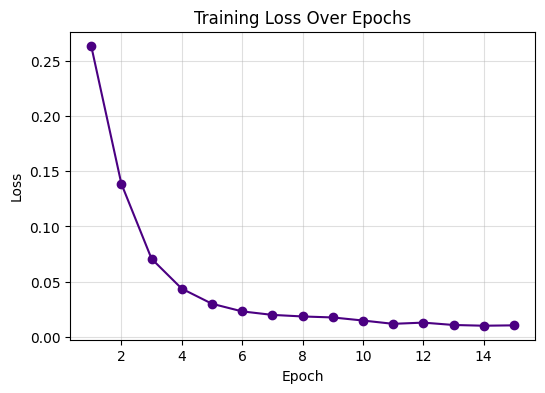

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(range(1, num_training_epochs+1), train_loss_history, marker='o', color='indigo')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.4)
plt.show()

# Evaluation: Predict and Compare Labels

In [ ]:
sentiment_model.eval()
all_predictions = []
all_ground_truths = []

with torch.no_grad():
    for batch in test_loader_full:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_predictions.extend(preds.cpu().numpy())
        all_ground_truths.extend(labels.cpu().numpy())

# Accuracy, F1 Score, and Confusion Matrix


Test Accuracy: 0.9200
Test F1 Score: 0.9196



<Figure size 500x400 with 0 Axes>

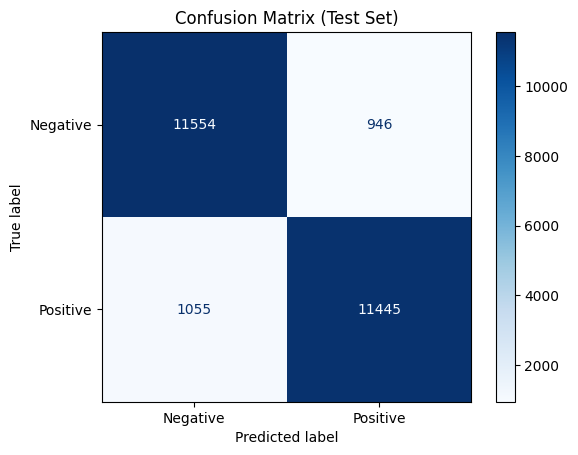

In [ ]:
final_accuracy = accuracy_score(all_ground_truths, all_predictions)
final_f1 = f1_score(all_ground_truths, all_predictions)

print(f"\nTest Accuracy: {final_accuracy:.4f}")
print(f"Test F1 Score: {final_f1:.4f}\n")

cm_final = confusion_matrix(all_ground_truths, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=['Negative', 'Positive'])
plt.figure(figsize=(5,4))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()


# Show Comments and Predicted Labels (After Training)

In [ ]:
print("\nSample test comments, true labels and model predictions (after training):\n")
for i in range(5):
    print(f"Review: {test_reviews[i][:120]}...")
    print(f"True label: {test_targets[i]}")
    print(f"Predicted label: {all_predictions[i]}")
    print("")


Sample test comments, true labels and model predictions (after training):

Review: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misun...
True label: 0
Predicted label: 0

Review: Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases,...
True label: 0
Predicted label: 0

Review: its a totally average film with a few semi-alright action sequences that make the plot seem a little better and remind t...
True label: 0
Predicted label: 0

Review: STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning <br /><br />Form...
True label: 0
Predicted label: 0

Review: First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. ...
True label: 0
Predicted label: 1

